In [1]:
%matplotlib inline


# PCEN Streaming


This notebook demonstrates how to use streaming IO with `librosa.pcen`
to do dynamic per-channel energy normalization on a spectrogram incrementally.

This is useful when processing long audio files that are too large to load all at
once, or when streaming data from a recording device.



We'll need numpy and matplotlib for this example



In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

import soundfile as sf

import librosa as librosa
import librosa.display as display

First, we'll start with an audio file that we want to stream



In [3]:
filename = librosa.util.example_audio_file()

Next, we'll set up the block reader to work on short segments of 
audio at a time.



In [4]:
# We'll generate 16 frames at a time, each frame having 4096 samples
# and 50% overlap.
#

n_fft = 4096
hop_length = n_fft // 2

# fill_value pads out the last frame with zeros so that we have a
# full frame at the end of the signal, even if the signal doesn't
# divide evenly into full frames.
sr = librosa.get_samplerate(filename)

stream = librosa.stream(filename, block_length=16,
                        frame_length=n_fft,
                        hop_length=hop_length,
                        mono=True,
                        fill_value=0)

For this example, we'll compute PCEN on each block, average over
frequency, and store the results in a list.



In [5]:
# Make an array to store the frequency-averaged PCEN values
pcen_blocks = []

# Initialize the PCEN filter delays to steady state
zi = None

for y_block in stream:
    # Compute the STFT (without padding, so center=False)
    D = librosa.stft(y_block, n_fft=n_fft, hop_length=hop_length,
                     center=False)

    # Compute PCEN on the magnitude spectrum, using initial delays
    # returned from our previous call (if any)
    # store the final delays for use as zi in the next iteration
    P, zi = librosa.pcen(np.abs(D), sr=sr, hop_length=hop_length,
                         zi=zi, return_zf=True)

    # Compute the average PCEN over frequency, and append it to our list
    pcen_blocks.extend(np.mean(P, axis=0))

# Cast to a numpy array for use downstream
pcen_blocks = np.asarray(pcen_blocks)

For the sake of comparison, let's see how it would look had we 
run PCEN on the entire spectrum without block-wise processing



In [6]:
y, sr = librosa.load(filename, sr=44100)

# Keep the same parameters as before
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, center=False)

# Compute pcen on the magnitude spectrum.
# We don't need to worry about initial and final filter delays if
# we're doing everything in one go.
P = librosa.pcen(np.abs(D), sr=sr, hop_length=hop_length)

pcen_full = np.mean(P, axis=0)

Plot the PCEN spectrum and the resulting magnitudes



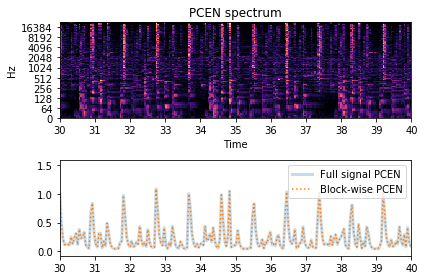

In [7]:
plt.figure()
# First, plot the spectrum
ax = plt.subplot(2,1,1)
librosa.display.specshow(P, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title('PCEN spectrum')

# Now we'll plot the pcen curves
plt.subplot(2,1,2, sharex=ax)
times = librosa.times_like(pcen_full, sr=sr, hop_length=hop_length)
plt.plot(times, pcen_full, linewidth=3, alpha=0.25, label='Full signal PCEN')
times = librosa.times_like(pcen_blocks, sr=sr, hop_length=hop_length)
plt.plot(times, pcen_blocks, linestyle=':', label='Block-wise PCEN')
plt.legend()

# Zoom in to a short patch to see the fine details
plt.xlim([30, 40])

# render the plot
plt.tight_layout()
plt.show()